<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/ChannelFlows/Simulation/ChannelFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as mpl
import numpy as np
from scipy.optimize import fsolve, fmin, minimize_scalar, curve_fit

In [ ]:
%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (12, 3)

# **Setup the problem**

In [ ]:
ρw = 1025   # salt water density [kg/m^3]
g   = 9.8   # gravity aceleration [m/s^2]

T = 12.0*3600.0 + 25.2*60.0 # tide period

L = 20000 # channel length [m]
h = 50    # channel depth [m]
b = 9000  # channel width [m]
a = 0.9   # tidel amplitude [m]
S = h*b   # channel area [m^2]    

ω = 2*np.pi / T         # tidal frequency
q0 = g*a*S / (ω*L)      # frictionless channel volumetric flow rate 
qr = S * np.sqrt(g*h)   # flow rate based on wave velocity

Cd  = 0.005   # friction coefficient [-]
f   = 2*Cd   # friction coefficient used in the model is twice the value 
             # usual used in tidal (non standard model) 

λTs = 0.5 * q0**2 / ( S**2 * g * a )
λfs = λTs * ( L / h )

# vector with blockage factor per row
B_rows = np.array( [ 0.15, 0.15, 0.1, 0.15, 0.15, 0.1 ] )

# **Solution of the ODE**

$\displaystyle \frac{dq^*}{dt^*}=\cos(t^*) - (\lambda_0^*+ \lambda_1^*) \, q^* \, |q^*|$

$\displaystyle \frac{de^*}{dt^*}= \lambda_2^* \, |{q^*}^3|$

where $\lambda_0^*$, $\lambda_1^*$ and $\lambda_2^*$ are known constants.


This system can be writen as

$$\dfrac{d \mathbf{y}^*}{dt^*} = \mathbf{f}^*\left( \mathbf{y}^*, t^* \right),$$

with

$$\mathbf{y} = 
\begin{pmatrix}
q^*\\
e^*
\end{pmatrix}
\tag{Eq. 1}
$$

and

$$
\tag{Eq. 2}
\mathbf{f}^* = 
\begin{pmatrix}
\cos(t^*) - (\lambda_0^*+\lambda_1^*) \, q^* \, |q^*|\\[4pt]
\lambda_2^* \, |{q^*}^3|
\end{pmatrix}
$$

We adopt a first order solution of the type

$$\dfrac{\mathbf{y}^*(t_n^*+\Delta t^*)-\mathbf{y}^*(t_n^*)}{\Delta t^*} 
= \mathbf{f}^*\bigg( t_n^*, \mathbf{y}^*\left(t_n^*\right) \bigg)$$

resulting

$$\mathbf{y}^*_{n+1} = \mathbf{y}^*_n + \Delta t^* \, \mathbf{f}^*\!\!\left( t^*_n,
\mathbf{y}^*_n  \right)
\tag{Eq. 3}
$$

where

$$\mathbf{y}^*_{n}=\mathbf{y}^*(t_n^*)$$

$$\mathbf{y}^*_{n+1}=\mathbf{y}^*(t_n^*+\Delta t^*)$$


# Define RHS of the ODE (Eq. 2)

In [ ]:
def fs( ys, ts, λ0s, λ1s, λ2s ):
    ( qs, es ) = ys 
    return np.array( ( np.cos( ts ) - ( λ0s + λ1s ) * qs * np.abs( qs ), 
             λ2s * np.abs( qs )**3 ) )

# **Lossless solution**

In [ ]:
periods = 4
ppp = 100 # points per period
num =  int(ppp*periods)

# stores time vector
ts_vec = np.linspace( 0, (2*np.pi) * periods, num )
Delta_ts = ts_vec[1] - ts_vec[0]

# vector that stores the solution time series
ys_lossless_vec = np.zeros( ( num, 2 ) )

# solution of (Eq. 3) without "friction" term
for i, ts in enumerate( ts_vec[1:] ):
  ys_lossless_vec[i+1] = ys_lossless_vec[i] + \
                       Delta_ts * fs( ys_lossless_vec[i], ts, 0, 0, 0 )

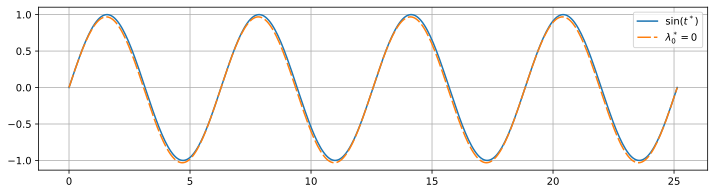

In [ ]:
mpl.plot( ts_vec, np.sin(ts_vec), label="$\sin(t^*)$" )
mpl.plot( ts_vec, ys_lossless_vec[:,0], dashes=(9,2), label="$\lambda_0^*=0$" )
mpl.grid()
mpl.legend();

# **Solution with channelbed friction and turbines thrust**



Turbine related parameters

In [ ]:
λP = 0.5 * ρw * q0**3 / S**2
print( "λP = %.2g W" % λP )

λP = 7.1e+09 W


In [ ]:
def compute_C_T_and_C_P( Fr4b, Fr1, B ): 

    # These Eqs. are described in
    # https://github.com/joaochenriques/MCTE_2020_2021/blob/main/DiskActuator/DiskActuator.ipynb

    ζ4 = (1/2.)*Fr1**2 - 1/2.*Fr4b**2 + 1.0
    
    Fr4t = (Fr1 - Fr4b*ζ4 + np.sqrt(B**2*Fr4b**2 - 2*B*Fr1**2 + 2*B*Fr1*Fr4b \
            + B*ζ4**2 - B + Fr1**2 - 2*Fr1*Fr4b*ζ4 + Fr4b**2*ζ4**2))/B

    ζ4b =  (Fr1 - Fr4t*ζ4)/(Fr4b - Fr4t)
    ζ4t = -(Fr1 - Fr4b*ζ4)/(Fr4b - Fr4t)
    
    Fr2t = Fr4t*ζ4t/B

    C_T = (Fr4b**2 - Fr4t**2)/Fr1**2
    C_P = C_T*Fr2t/Fr1

    return C_T, C_P

def find_minus_C_P( Fr4b, Fr1, B ): 
    # function created to discard the C_T when calling "compute_C_T_and_C_P"
    C_T, C_P = compute_C_T_and_C_P( Fr4b, Fr1, B ) 
    return -C_P # Minus C_P to allow minimization

In [ ]:
def compute_λ1s_λ2s( h, q0, qr, B_rows, λTs, qs ):

  C_T_rows = np.zeros( B_rows.shape )
  C_P_rows = np.zeros( B_rows.shape )
  λ1s = λ2s = 0.0

  h1  = h
  Fr1 = np.abs( qs * q0 / qr )

  if Fr1 < 1E-3:
    return λ1s, λ2s, C_T_rows, C_P_rows # all zeros

  for i, B in enumerate( B_rows ):
    
    # find the optimal C_P for the channel conditions
    res = minimize_scalar( find_minus_C_P, args=(Fr1, B), bounds=[0,1], method='bounded', 
                          options={ 'xatol': 1e-08, 'maxiter': 500, 'disp': 1 } )
    Fr4b = res.x # optimal value

    C_T, C_P = compute_C_T_and_C_P( Fr4b, Fr1, B )

    C_T_rows[i] = C_T
    C_P_rows[i] = C_P

    λ1s += λTs * B * C_T
    λ2s += B * C_P

  return λ1s, λ2s, C_T_rows, C_P_rows

In [ ]:
C_T_max = C_P_max = 0.0
λ1s_max = λ2s_max = 0.0

λ0s = λfs * f

# vector that stores the solution time series
ys_vec = np.zeros( ( num, 2 ) )

# The initial condition is (0,0) => C_T, C_P = 0

# solution of (Eq. 3) with "friction" terms
for i, ts in enumerate( ts_vec[1:] ):

  λ1s, λ2s, C_T_rows, C_P_rows = compute_λ1s_λ2s( h, q0, qr, B_rows, λTs, ys_vec[i][0] )

  ys_vec[i+1] = ys_vec[i] + Delta_ts * fs( ys_vec[i], ts, λ0s, λ1s, λ2s )

  C_T_max = np.max( ( C_T_max, np.max( C_T_rows ) ) )
  C_P_max = np.max( ( C_P_max, np.max( C_P_rows ) ) )
  λ1s_max = np.max( ( λ1s, λ1s_max ) )
  λ2s_max = np.max( ( λ2s, λ2s_max ) )

print( "λ0s = %.4f" % λ0s )
print( "λ1s_max = %.3f" % λ1s_max ) 
print( "λ2s_max = %.3f" % λ2s_max ) 
print( "C_T_max = %.3f" % C_T_max ) 
print( "C_P_max = %.3f" % C_P_max ) 

λ0s = 2.2332
λ1s_max = 0.611
λ2s_max = 0.640
C_T_max = 1.421
C_P_max = 0.823


q_max^* = 0.56611
u_max   = 1.777 m/s


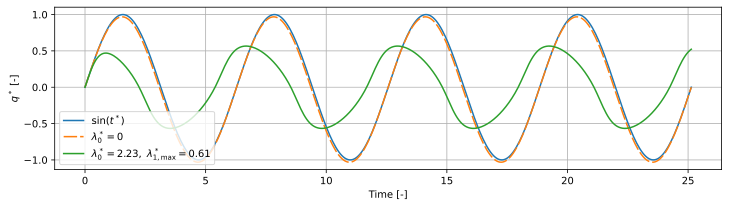

In [ ]:
mpl.plot( ts_vec, np.sin(ts_vec), label="$\sin(t^*)$" )
mpl.plot( ts_vec, ys_lossless_vec[:,0], dashes=(9,2), label="$\lambda_0^*=0$" );
mpl.plot( ts_vec, ys_vec[:,0], label="$\lambda_0^*=%.2f,\ \lambda_\mathrm{1,max}^*=%.2f$" % (λ0s,λ1s_max) )
mpl.grid()
mpl.xlabel( "Time [-]")
mpl.ylabel( "$q^*$ [-]")
mpl.legend( loc = 'lower left')

qmax = np.max(ys_vec[-ppp:,0])
umax = qmax * q0 / S

print( "q_max^* = %.5f" % qmax ) 
print( "u_max   = %.3f m/s" % umax )

Plot the energy of the last period

P^* = 0.052, Pt = 371.123 MW


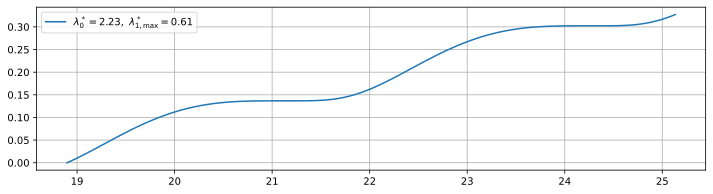

In [ ]:
es_last_period = ys_vec[-ppp:,1]    # data of the last period 
es_last_period -= es_last_period[0] # Zero energy at the begining of last period

Ps = es_last_period[-1] / (2*np.pi) # Time averaged converted power on last period (energy/period)    
print( "P^* = %.3f, Pt = %.3f MW" % ( Ps, Ps*λP/1E6 ) )

mpl.plot( ts_vec[-ppp:], es_last_period, label="$\lambda_0^*=%.2f,\ \lambda_\mathrm{1,max}^*=%.2f$" % (λ0s,λ1s_max) )
mpl.grid()
mpl.legend( loc = 'upper left');